In [1]:
import numpy 
from matplotlib import pyplot
from amuse.units import units, constants
from amuse.lab import nbody_system
from amuse.couple import bridge
from amuse.community.huayno import Huayno
from amuse.ic.salpeter import new_salpeter_mass_distribution
from amuse.ic.plummer import new_plummer_model
from amuse.ic.fractalcluster import new_fractal_cluster_model
from amuse.lab import Particle, Particles, units, nbody_system
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import math, numpy
from matplotlib import pyplot
from amuse.lab import *
from optparse import OptionParser
from amuse.ext.LagrangianRadii import LagrangianRadii
from amuse.community.ph4.interface import ph4

/home/zuzia/miniforge3/lib/python3.12/site-packages/amuse/support/options.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
class MilkyWay_galaxy(object):
    def __init__(
        self, 
        Mb=1.40592e10 | units.MSun,
        Md=8.5608e10 | units.MSun,
        Mh=1.07068e11 | units.MSun,
    ):
        self.Mb = Mb
        self.Md = Md
        self.Mh = Mh

    def get_potential_at_point(self,eps,x,y,z):
        r = (x**2+y**2+z**2)**0.5
        R = (x**2+y**2)**0.5
        # bulge
        b1 = 0.3873 | units.kpc
        pot_bulge = -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+ (z**2+ b2**2)**0.5 )**2 )**0.5
        # halo
        a3 = 12.0 | units.kpc
        cut_off = 100 | units.kpc
        d1= r/a3
        c = 1+ (cut_off/a3)**1.02
        pot_halo = (
            -constants.G * (self.Mh/a3) * d1**1.02/(1+ d1**1.02)
            -(constants.G*self.Mh/(1.02*a3))
            * (
                -1.02 / c + numpy.log(c) + 1.02/(1+d1**1.02) 
                - numpy.log(1.0 + d1**1.02)
            )
        )
        return 2*(pot_bulge+pot_disk+ pot_halo)  # multiply by 2 because it is a rigid potential
    
    def get_gravity_at_point(self, eps, x,y,z): 
        r = (x**2+y**2+z**2)**0.5
        R = (x**2+y**2)**0.5
        # bulge
        b1 = 0.3873 | units.kpc
        force_bulge = -constants.G*self.Mb/(r**2+b1**2)**1.5 
        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        d = a2+ (z**2+ b2**2)**0.5
        force_disk = -constants.G*self.Md/(R**2+ d**2 )**1.5
        # halo
        a3 = 12.0 | units.kpc
        d1 = r/a3
        force_halo = -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))
       
        ax = force_bulge*x + force_disk*x  + force_halo*x/r
        ay = force_bulge*y + force_disk*y  + force_halo*y/r
        az = force_bulge*z + force_disk*d*z/(z**2 + b2**2)**0.5 + force_halo*z/r 

        return ax,ay,az

In [8]:
#setting the initial conditions - number of stars, velocity of the cluster, size of a cluster, position of a cluster
number_of_stars = 100
vel_cluster = 40

masses = new_salpeter_mass_distribution(number_of_stars, 1|units.MSun, 30|units.MSun)
#set to a 1000 particles cluster 
converter = nbody_system.nbody_to_si(masses.sum(), 1|units.parsec)

cluster = new_fractal_cluster_model(number_of_stars, converter)
cluster.mass = masses
cluster.move_to_center()
cluster.position += [8.5, 0, 0] | units.kpc
cluster.velocity += [0, vel_cluster, 0] |units.kms
# Assign a simple integer ID 0, 1, 2... to easily identify them later
cluster.id = range(len(cluster))

# Verify the massive ones
print(f"Most massive star ID: {cluster[cluster.mass.argmax()].id} (Mass: {cluster.mass.max().in_(units.MSun)})")


# print(cluster.x.value_in(units.parsec).min())
# print(cluster.x.value_in(units.parsec).max())

# print(cluster[2].mass)
cluster.radius = 500 | units.AU
print(cluster.radius.in_(units.AU))
print(cluster.virial_radius().in_(units.AU))

cluster_star_mass = []
for i in range(len(cluster)):
    cluster_star_mass.append(cluster[i].mass.value_in(units.MSun))

Most massive star ID: 83 (Mass: 27.2440813151 MSun)
[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0] au
184891.466319 au


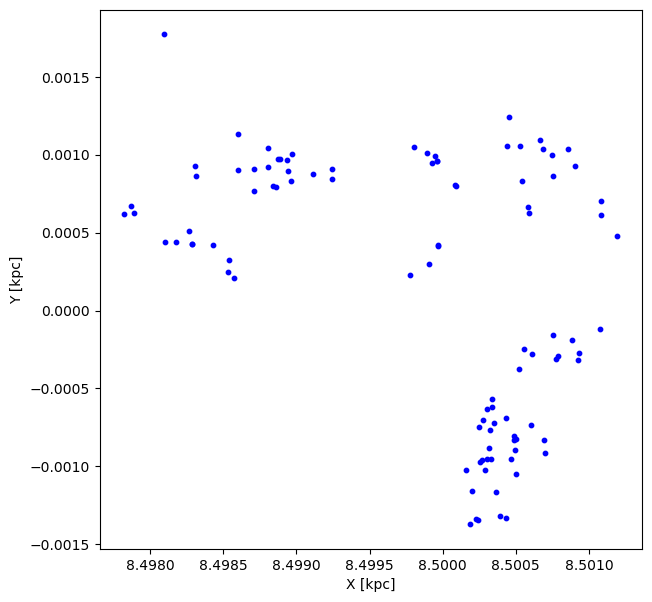

In [9]:
plt.figure(figsize=(7, 7))
plt.scatter(cluster.x.value_in(units.kpc), cluster.y.value_in(units.kpc), c='blue', s=10)
plt.xlabel("X [kpc]")
plt.ylabel("Y [kpc]")
plt.show()

In [10]:
# Save original velocities so we don't break the simulation
original_velocities = cluster.velocity.copy()

# 1. Calculate Center of Mass Velocity
v_cm = cluster.center_of_mass_velocity()
print(f"Center of Mass Velocity: {v_cm.in_(units.kms)}")

# 2. Shift to Center of Mass Frame (Remove bulk motion)
cluster.velocity -= v_cm

# 3. Calculate Energy of the cluster internals
K_internal = cluster.kinetic_energy()
U_internal = cluster.potential_energy()
Q_internal = K_internal / abs(U_internal)
E_internal = K_internal + U_internal

print("-" * 30)
print(f"Internal Kinetic Energy (K): {K_internal.in_(units.J)}")
print(f"Internal Potential Energy (U): {U_internal.in_(units.J)}")
print(f"Internal Virial Ratio (Q):   {Q_internal}")
print(f"Internal Total Energy (E):   {E_internal.in_(units.J)}")

# 4. RESTORE velocities (Critical! Otherwise your simulation stops moving!)
cluster.velocity = original_velocities


Center of Mass Velocity: [2.8655402856e-18, 40.0, 1.74661503123e-17] kms
------------------------------
Internal Kinetic Energy (K): 1.3930923679e+38 J
Internal Potential Energy (U): -3.36447429691e+38 J
Internal Virial Ratio (Q):   0.4140594473213598
Internal Total Energy (E):   -1.971381929e+38 J


so try new with starting the new simulation

In [37]:
t_end = 100 | units.Myr
dt = 0.1 | units.Myr
MWG = MilkyWay_galaxy()
t = 0 | units.Myr
limit = 0.01 |units.AU

t_history = []
x_history = []
y_history = []
z_history = []

gravity_code = ph4(converter, number_of_workers=1)
gravity_code.particles.add_particles(cluster)

channel_from_gd_to_framework = gravity_code.particles.new_channel_to(cluster)

print("start",gravity_code.model_time.in_(units.Myr))
stopping_condition = gravity_code.stopping_conditions.collision_detection
stopping_condition.enable()

gravity = bridge.Bridge(use_threading=False)
gravity.add_system(gravity_code, (MWG,) )
gravity.evolve_model(t+dt)

print("start2",gravity_code.model_time.in_(units.Myr))
interactions_list =[]
i = 0                     

while t < t_end:
    if stopping_condition.is_set():
        # print(gravity.model_time.in_(units.yr))
        t = gravity_code.model_time.in_(units.yr)
        print(gravity_code.model_time.in_(units.yr))
        t_history.append(gravity_code.model_time.in_(units.yr))
        x_history.append(cluster.x.value_in(units.parsec))
        y_history.append(cluster.y.value_in(units.parsec))
        z_history.append(cluster.z.value_in(units.parsec))
        # # print("Collision detected")
        # print(stopping_condition.particles(0), stopping_condition.particles(1))
        #print("time:", t.in_(units.yr))
        part_set_1 = stopping_condition.particles(0)
            
        part_set_2 = stopping_condition.particles(1)
        
        for p1, p2 in zip(part_set_1, part_set_2):
            p1.radius = p1.radius/2
            p2.radius = p2.radius/2
            if p1.radius < limit:
                p1.radius = 0 | units.AU
            if p2.radius < limit:
                p2.radius = 0 | units.AU
            if p1.mass < p2.mass:
                mass_ratio = p2.mass / p1.mass
            else:
                mass_ratio = p1.mass / p2.mass

        # gravity = bridge.Bridge(use_threading=False)
        # gravity.add_system(gravity_code, (MWG,) )
        interactions_list.append((gravity_code.model_time.in_(units.yr), stopping_condition.particles(0).key, stopping_condition.particles(1).key, p1.radius.in_(units.AU), p2.radius.in_(units.AU),p1.x.in_(units.kpc),p1.y.in_(units.kpc),p1.z.in_(units.kpc),p2.x.in_(units.kpc),p2.y.in_(units.kpc),p2.z.in_(units.kpc),p1.vx.in_(units.kms),p1.vy.in_(units.kms),p1.vz.in_(units.kms),p2.vx.in_(units.kms),p2.vy.in_(units.kms),p2.vz.in_(units.kms),p1.mass.in_(units.MSun),p2.mass.in_(units.MSun),mass_ratio))
        gravity.evolve_model(t+dt)
        i += 1
    else:
        t += dt
        gravity.evolve_model(t)
        channel_from_gd_to_framework.copy()
        # print("time next step:", t.in_(units.kyr))
        # print("gravity code time:", gravity_code.model_time.in_(units.kyr))
        cluster.radius = 500 | units.AU

print("end",gravity_code.model_time.in_(units.Myr))
gravity.stop()
print(interactions_list)

start 0.0 Myr
start2 0.0631058062479 Myr
63105.8062479 yr
63850.3417976 yr
64152.0070634 yr
66648.7685189 yr
72682.0738356 yr
73092.8520699 yr
73234.0570879 yr
73287.0089697 yr
73309.4734044 yr
74299.5131332 yr
74825.8227459 yr
75031.2118631 yr
75111.441987 yr
87341.722073 yr
87906.5421452 yr
88111.9312623 yr
88185.7429763 yr
88213.0212184 yr
88224.6545864 yr
94478.9938943 yr
95351.8976423 yr
95358.3160522 yr
95666.3997279 yr
95775.5126964 yr
95814.0231559 yr
95828.0634276 yr
95833.2783856 yr
95835.5850017 yr
96250.4750299 yr
96539.3034759 yr
96651.6256493 yr
96693.3453137 yr
96708.5890373 yr
96718.0160768 yr
97457.1360932 yr
98150.3243636 yr
98413.47917 yr
98522.5921385 yr
100281.236454 yr
100923.077445 yr
101147.721792 yr
101227.951916 yr
101257.637062 yr
101268.468129 yr
101273.081361 yr
102822.926779 yr
103285.052293 yr
103458.34936 yr
103520.928857 yr
103554.625509 yr
112964.014439 yr
114093.654583 yr
114504.432818 yr
114677.729885 yr
117842.005971 yr
118740.583359 yr
119080.75908

In [11]:
t_end = 10 | units.Myr
dt = 0.1 | units.Myr
MWG = MilkyWay_galaxy()
t = 0 | units.Myr
limit = 0.01 |units.AU

t_history = []
x_history = []
y_history = []
z_history = []
v_cm = cluster.center_of_mass_velocity()
print(f"Center of Mass Velocity: {v_cm.in_(units.kms)}")

# 2. Shift to Center of Mass Frame (Remove bulk motion)
cluster.velocity -= v_cm

gravity_code = ph4(converter, number_of_workers=1)
gravity_code.particles.add_particles(cluster)

channel_from_gd_to_framework = gravity_code.particles.new_channel_to(cluster)

print("start",gravity_code.model_time.in_(units.Myr))
stopping_condition = gravity_code.stopping_conditions.collision_detection
stopping_condition.enable()

gravity = bridge.Bridge(use_threading=False)
gravity.add_system(gravity_code, (MWG,) )
gravity.evolve_model(t+dt)

print("start2",gravity_code.model_time.in_(units.Myr))
interactions_list =[]
i = 0                     

while t < t_end:
    if stopping_condition.is_set():
        # print(gravity.model_time.in_(units.yr))
        t = gravity_code.model_time.in_(units.yr)
        print(gravity_code.model_time.in_(units.yr))
        t_history.append(gravity_code.model_time.in_(units.yr))
        x_history.append(cluster.x.value_in(units.parsec))
        y_history.append(cluster.y.value_in(units.parsec))
        z_history.append(cluster.z.value_in(units.parsec))
        
        K_internal = cluster.kinetic_energy()
        U_internal = cluster.potential_energy()
        Q = K_internal / abs(U_internal)
        E_tot = K_internal + U_internal
        # # print("Collision detected")
        # print(stopping_condition.particles(0), stopping_condition.particles(1))
        #print("time:", t.in_(units.yr))
        part_set_1 = stopping_condition.particles(0)
            
        part_set_2 = stopping_condition.particles(1)
        
        for p1, p2 in zip(part_set_1, part_set_2):
            p1.radius = p1.radius/2
            p2.radius = p2.radius/2
            if p1.radius < limit:
                p1.radius = 0 | units.AU
            if p2.radius < limit:
                p2.radius = 0 | units.AU
            if p1.mass < p2.mass:
                mass_ratio = p2.mass / p1.mass
            else:
                mass_ratio = p1.mass / p2.mass

        # gravity = bridge.Bridge(use_threading=False)
        # gravity.add_system(gravity_code, (MWG,) )
        interactions_list.append((gravity_code.model_time.in_(units.yr), stopping_condition.particles(0).key, stopping_condition.particles(1).key, p1.radius.in_(units.AU), p2.radius.in_(units.AU),p1.x.in_(units.kpc),p1.y.in_(units.kpc),p1.z.in_(units.kpc),p2.x.in_(units.kpc),p2.y.in_(units.kpc),p2.z.in_(units.kpc),p1.vx.in_(units.kms),p1.vy.in_(units.kms),p1.vz.in_(units.kms),p2.vx.in_(units.kms),p2.vy.in_(units.kms),p2.vz.in_(units.kms),p1.mass.in_(units.MSun),p2.mass.in_(units.MSun),mass_ratio, E_tot.in_(units.erg), Q))
        gravity.evolve_model(t+dt)
        i += 1
    else:
        t += dt
        gravity.evolve_model(t)
        channel_from_gd_to_framework.copy()
        # print("time next step:", t.in_(units.kyr))
        # print("gravity code time:", gravity_code.model_time.in_(units.kyr))
        cluster.radius = 500 | units.AU

print("end",gravity_code.model_time.in_(units.Myr))
gravity.stop()
print(interactions_list)

Center of Mass Velocity: [2.8655402856e-18, 40.0, 1.74661503123e-17] kms
start 0.0 Myr
start2 0.0661730358811 Myr
66173.0358811 yr
66787.3003492 yr
67080.4720272 yr
67108.3931393 yr
67202.626893 yr
67270.6846039 yr
67485.3281539 yr
67673.7956611 yr
68741.7782022 yr
69258.3187777 yr
69453.766563 yr
69541.0200386 yr
94764.2547597 yr
95434.3614522 yr
96942.1015102 yr
97807.655988 yr
98114.788222 yr
98229.9628098 yr
98280.5698256 yr
99706.2916167 yr
99964.5619044 yr
100055.305519 yr
100085.844235 yr
100097.187187 yr
100101.440794 yr
100103.022263 yr
100103.594864 yr
100103.840265 yr
104676.249586 yr
105039.224044 yr
105206.750717 yr
106267.75298 yr
106644.687995 yr
106854.096336 yr
119725.729054 yr
120563.36242 yr
120856.534098 yr
120957.748129 yr
120996.139659 yr
121011.409017 yr
121018.607429 yr
133714.206259 yr
134077.180718 yr
134209.806001 yr
134256.922877 yr
134275.682375 yr
134283.317054 yr
145905.261868 yr
145928.820306 yr
145937.981921 yr
145942.889929 yr
149322.107971 yr
150271.4

In [12]:
import csv

# 1. Prepare a clean list of lists
clean_rows = []

for row_tuple in interactions_list:
    cleaned_row = []
    for item in row_tuple:
        # Check if the item is an AMUSE Quantity (has a unit attached)
        if hasattr(item, "number"):
            # .number strips the unit (since you already did .in_() in the main loop)
            cleaned_row.append(item.number)
        
        # Check if the item is a numpy array (like the keys/IDs usually are)
        elif hasattr(item, "__len__") and not isinstance(item, str):
            # Take the first item if it's a list/array (e.g. key [102] -> 102)
            cleaned_row.append(item[0])
            
        # Fallback for standard python types
        else:
            cleaned_row.append(item)
            
    clean_rows.append(cleaned_row)

# 2. Write to CSV
with open("Interactions stopping conditions_10Myr.csv", "w", newline="") as f:
    writer = csv.writer(f)
    # Write header
    writer.writerow(["time (yr)", "particle1_id", "particle2_id", "particle1_radius (AU)", "particle2_radius (AU)", "particle1_x (kpc)","particle1_y (kpc)","particle1_z (kpc)","particle2_x (kpc)","particle2_y (kpc)","particle2_z (kpc)","particle1_vx (km/s)","particle1_vy (km/s)","particle1_vz (km/s)","particle2_vx (km/s)","particle2_vy (km/s)","particle2_vz (km/s)","particle1_mass (MSun)","particle2_mass (MSun)","mass_ratio", "total_energy (erg)", "virial_ratio (Q)"])
    # Write data
    writer.writerows(clean_rows)

print("Interactions saved successfully to interactions.csv")

Interactions saved successfully to interactions.csv


Plot of a trajectory

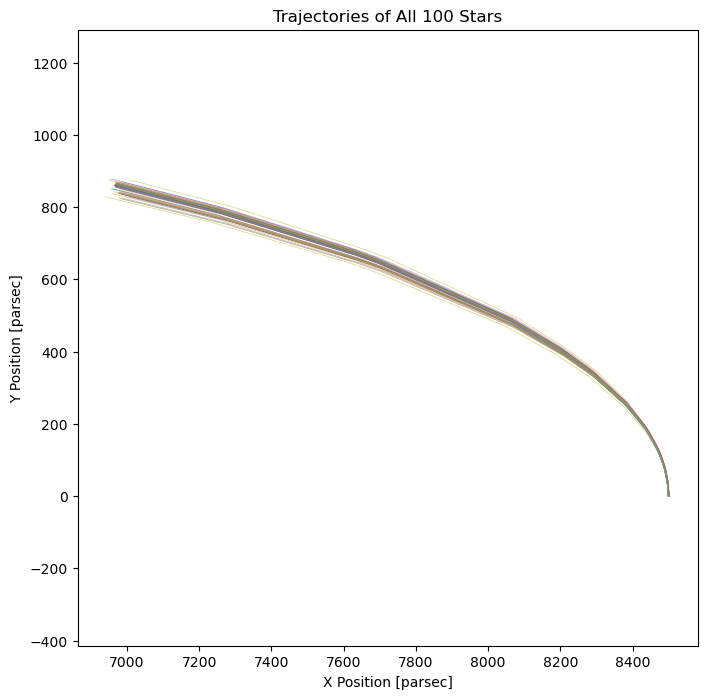

In [17]:
import matplotlib.pyplot as plt
times = numpy.array(t_history)          # Shape: (steps,)
x_all = numpy.array(x_history).T        # Shape: (stars, steps)
y_all = numpy.array(y_history).T        # Shape: (stars, steps)
z_all = numpy.array(z_history).T        # Shape: (stars, steps

# 1. Setup the figure
plt.figure(figsize=(8, 8))

# 2. Iterate through every star and plot its line
# x_all.shape[0] is the number of stars
for i in range(x_all.shape[0]):
    # x_all[i] is the full history of X positions for star 'i'
    # y_all[i] is the full history of Y positions for star 'i'
    
    # We use a thin line (linewidth=0.5) and slight transparency (alpha=0.6) 
    # so it doesn't look too messy if there are many stars.
    plt.plot(x_all[i], y_all[i], linewidth=0.5, alpha=0.6)

# 3. Add labels and title
plt.xlabel('X Position [parsec]')
plt.ylabel('Y Position [parsec]')
plt.title(f'Trajectories of All {x_all.shape[0]} Stars')

# Optional: Ensure the aspect ratio is equal so circles look like circles
plt.axis('equal')

# 4. Show the plot
plt.show()


Here is an animation of trajectoy but it is not working well...

In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# --- SETTINGS ---
# Skip frames to make generation faster (e.g., 5 means plot every 5th time step)
#skip_step = 5 
# Total available steps in your data
total_data_steps = x_all.shape[1] 

fig, ax = plt.subplots(figsize=(7, 7))

lines = []

# 1. Initialize the lines
for i in range(number_of_stars):
    # Initialize with empty data
    # Note: ax.plot returns a list, so we unwrap it with comma: line, = ...
    line, = ax.plot([], [], lw=1, alpha=0.7, label=f"Star {i}")
    lines.append(line)

# 2. Set Axis Limits Automatically based on the data range
# Adding a 10% margin so stars don't hit the edge
x_min, x_max = x_all.min(), x_all.max()
y_min, y_max = y_all.min(), y_all.max()
margin_x = (x_max - x_min) * 0.1
margin_y = (y_max - y_min) * 0.1

# ax.set_xlim(x_min - margin_x, x_max + margin_x)
# ax.set_ylim(y_min - margin_y, y_max + margin_y)
ax.set_xlim(8450,8550)
ax.set_ylim(-20,20)

ax.set_xlabel("x [pc]")
ax.set_ylabel("y [pc]")
ax.set_title(f"Cluster Evolution ({t_end})")

# 3. Update Function
def update(frame):
    # frame is the index of the time step
    for i in range(number_of_stars):
        # Slice from start (0) to current frame to show the full trail
        # x_all[star_index, 0:current_time_index]
        x = x_all[i, :frame]
        y = y_all[i, :frame]
        
        lines[i].set_data(x, y)
    return lines 

# 4. Generate Animation
frames=range(0, total_data_steps) #makes it lighter/faster to generate
ani = animation.FuncAnimation(
    fig=fig, 
    func=update, 
    frames=frames, 
    interval=30, 
    blit=True
)

plt.close() # Prevents showing the static plot underneath
HTML(ani.to_jshtml())


Data analyzing

In [25]:
import pandas as pd
data = pd.DataFrame(clean_rows, columns=["time (yr)", "particle1_id", "particle2_id", "particle1_radius (AU)", "particle2_radius (AU)", "particle1_x (kpc)","particle1_y (kpc)","particle1_z (kpc)","particle2_x (kpc)","particle2_y (kpc)","particle2_z (kpc)","particle1_vx (km/s)","particle1_vy (km/s)","particle1_vz (km/s)","particle2_vx (km/s)","particle2_vy (km/s)","particle2_vz (km/s)","particle1_mass (MSun)","particle2_mass (MSun)","mass_ratio"])

print(data)


        time (yr)          particle1_id          particle2_id  \
0    5.433088e+04   9972144329722947480  17078543010717915420   
1    5.483654e+04  17078543010717915420   9972144329722947480   
2    5.501915e+04  17078543010717915420   9972144329722947480   
3    5.508235e+04   9972144329722947480  17078543010717915420   
4    5.510386e+04  17078543010717915420   9972144329722947480   
..            ...                   ...                   ...   
206  1.627103e+07   6347014990189676858   9590525808437135129   
207  1.630437e+07   9590525808437135129   6347014990189676858   
208  1.693331e+07   6902546172677459140   6217336344585993459   
209  2.014924e+07   9522214134995521491   7545924179536627550   
210  2.233053e+07    818284027267343328    721392063410985992   

     particle1_radius (AU)  particle2_radius (AU)  particle1_x (kpc)  \
0               250.000000               250.0000           8.498476   
1               125.000000               125.0000           8.498478   
2  

In [46]:
# 1. Combine both ID columns into a single Series
all_ids = pd.concat([data["particle1_id"], data["particle2_id"]])

# 2. Get unique IDs
unique_ids = all_ids.unique()

# 3 the procentege of stars with interaction 
procentage = (len(unique_ids) / number_of_stars) * 100
print(f"Percentage of stars with interactions: {procentage:.2f}%")


Percentage of stars with interactions: 82.00%


In [47]:
# 1. Create a "long" format of interactions: [Star_A, Star_B]
# We stack the dataframe so we have (p1, p2) AND (p2, p1) to ensure we count interactions for both sides
df_pairs = pd.concat([
    data[["particle1_id", "particle2_id"]].rename(columns={"particle1_id": "Star", "particle2_id": "Partner"}),
    data[["particle2_id", "particle1_id"]].rename(columns={"particle2_id": "Star", "particle1_id": "Partner"})
])

# 2. Group by "Star" and count unique "Partners"
# This prevents counting multiple collisions with the same star as "new" unique interactions
interaction_counts = df_pairs.groupby("Star")["Partner"].nunique()

# 3. Find the star with the maximum count
most_active_star_id = interaction_counts.idxmax()
max_interactions = interaction_counts.max()

print(f"Star with most unique interactions: ID {int(most_active_star_id)}")
print(f"Number of unique partners: {max_interactions}")

# Optional: Print the list of partners for that star
partners = df_pairs[df_pairs["Star"] == most_active_star_id]["Partner"].unique()
print(f"Partners: {sorted(partners)}")


Star with most unique interactions: ID 818284027267343328
Number of unique partners: 6
Partners: [599418362100563066, 721392063410985992, 3709338932966160188, 11922712441207651443, 11944551086085460172, 13558736080769110317]


In [48]:
# 1. Find the index of the row with the maximum mass_ratio
max_ratio_index = data["mass_ratio"].idxmax()

# 2. Extract that specific row
max_ratio_row = data.loc[max_ratio_index]

print(f"Biggest Mass Ratio: {max_ratio_row['mass_ratio']:.4f}")
print("-" * 30)
print("Interaction Details:")
print(max_ratio_row)


Biggest Mass Ratio: 18.8047
------------------------------
Interaction Details:
time (yr)                7.587220e+05
particle1_id             6.012379e+18
particle2_id             1.532249e+19
particle1_radius (AU)    3.906250e+00
particle2_radius (AU)    2.500000e+02
particle1_x (kpc)        8.499078e+00
particle1_y (kpc)        2.939961e-02
particle1_z (kpc)        1.258507e-04
particle2_x (kpc)        8.499078e+00
particle2_y (kpc)        2.939970e-02
particle2_z (kpc)        1.234638e-04
particle1_vx (km/s)     -4.884301e+00
particle1_vy (km/s)      3.940515e+01
particle1_vz (km/s)     -2.206579e-01
particle2_vx (km/s)     -5.471870e+00
particle2_vy (km/s)      3.343733e+01
particle2_vz (km/s)      6.075442e+00
particle1_mass (MSun)    2.075858e+01
particle2_mass (MSun)    1.103905e+00
mass_ratio               1.880467e+01
Name: 138, dtype: float64
